**#IPL Score Prediction using Deep Learning**


1. Installing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import keras
import tensorflow as tf

2. Loading the Dataset

In [2]:
ipl = pd.read_csv('ipl_data.csv')
ipl.head()

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222


3. Exploratory Data Analysis

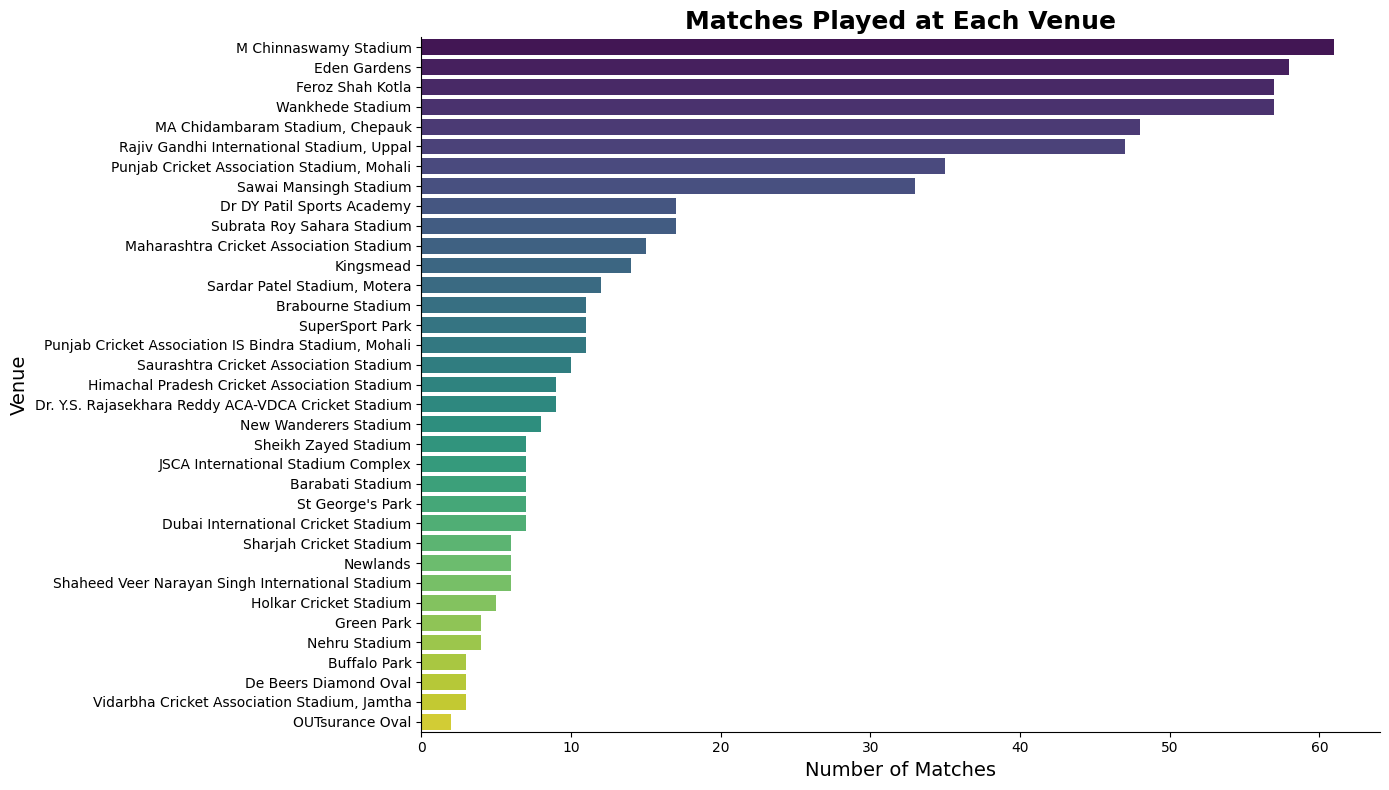

In [16]:
data = ipl.copy()
matches_per_venue = data[['mid', 'venue']].drop_duplicates()
matches_count = matches_per_venue['venue'].value_counts()

plt.figure(figsize=(14, 8))
sns.barplot(
    y=matches_count.index,
    x=matches_count.values,
    palette="viridis"
)
plt.title("Matches Played at Each Venue", fontsize=18, weight='bold')
plt.xlabel("Number of Matches", fontsize=14)
plt.ylabel("Venue", fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

Top 10 batsmen with the highest runs

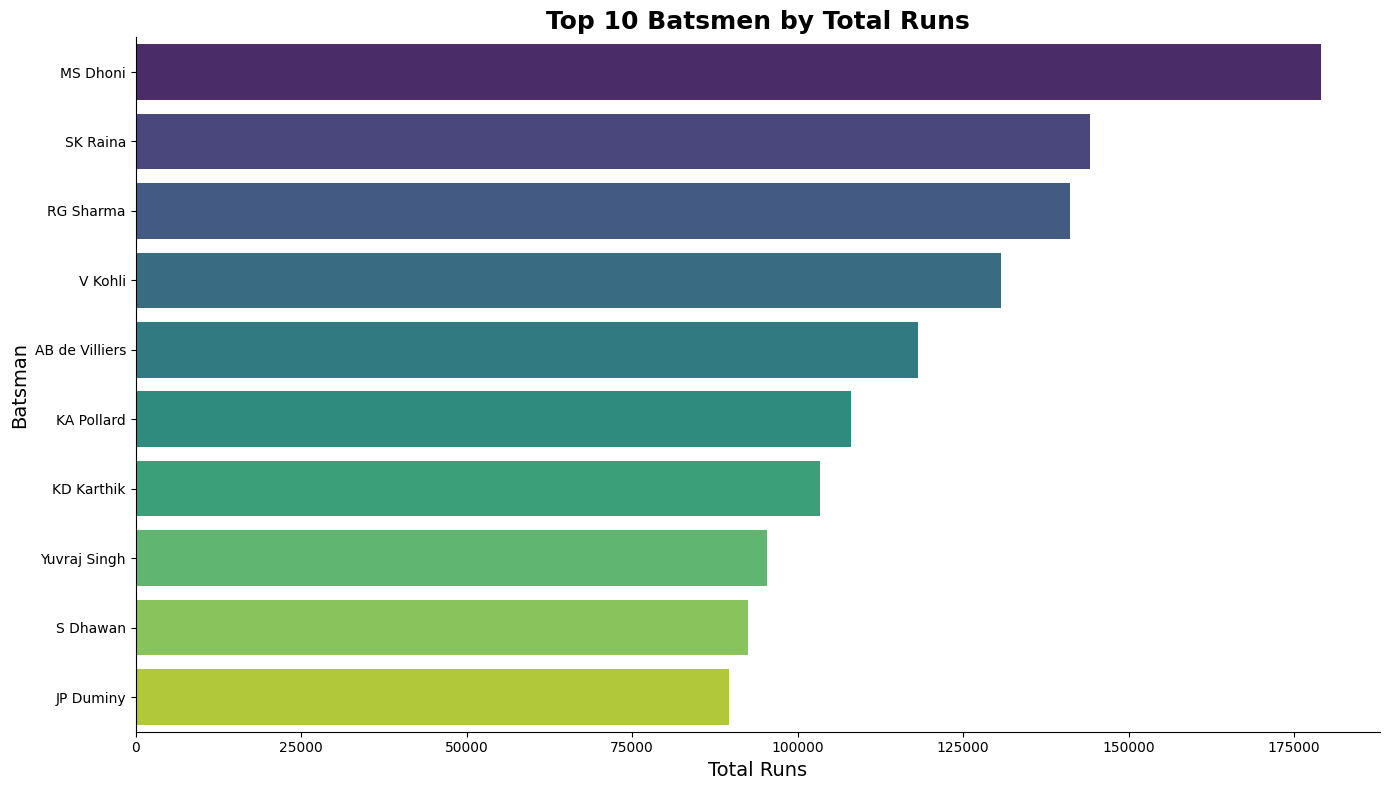

In [23]:
top_batsmen = data.groupby("batsman")["runs"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 8))
sns.barplot(
    x=top_batsmen.values,
    y=top_batsmen.index,
    palette="viridis"
)
plt.title("Top 10 Batsmen by Total Runs", fontsize=18, weight='bold')
plt.xlabel("Total Runs", fontsize=14)
plt.ylabel("Batsman", fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

Top 10 bowlers by Wickets Taken

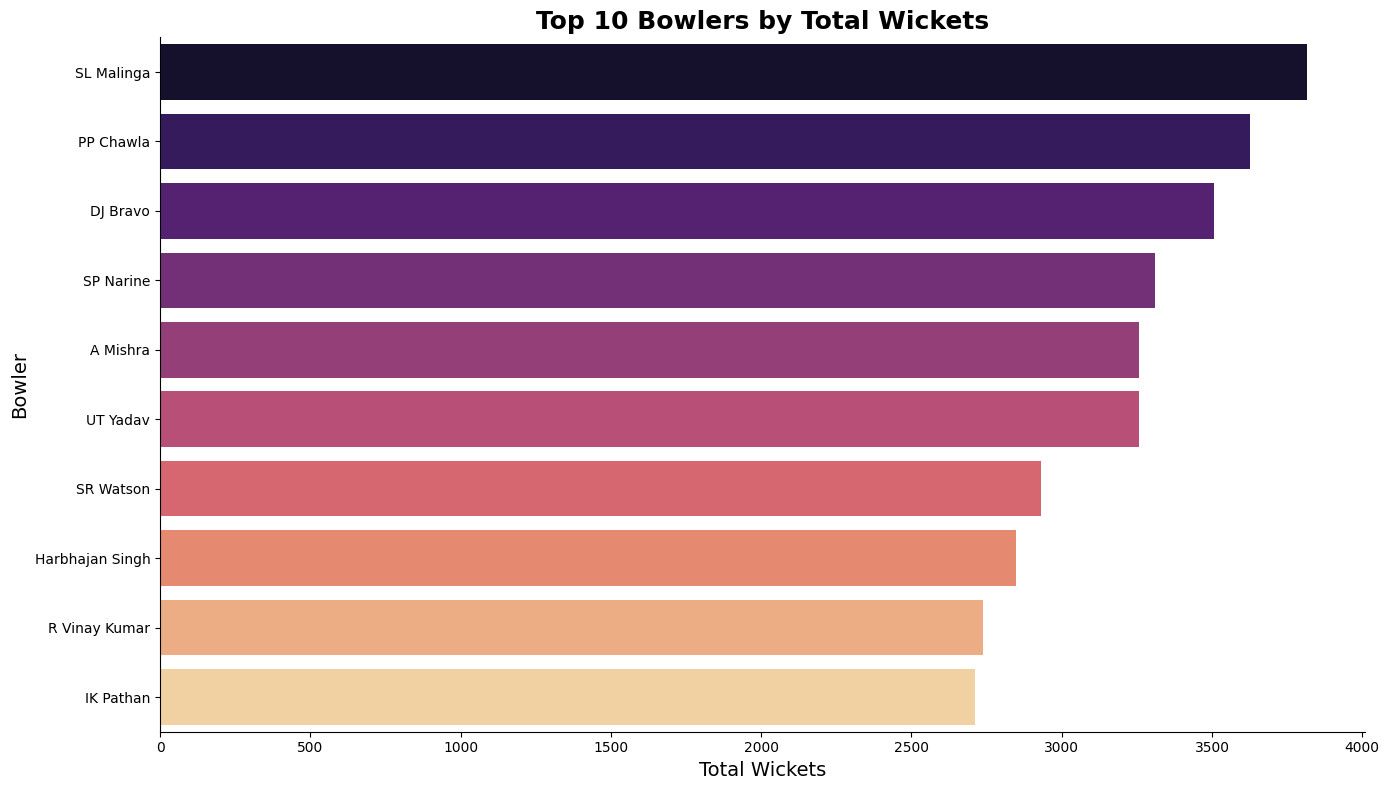

In [25]:
top_bowlers = data.groupby("bowler")["wickets"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 8))
sns.barplot(
    x=top_bowlers.values,
    y=top_bowlers.index,
    palette="magma"
)
plt.title("Top 10 Bowlers by Total Wickets", fontsize=18, weight='bold')
plt.xlabel("Total Wickets", fontsize=14)
plt.ylabel("Bowler", fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

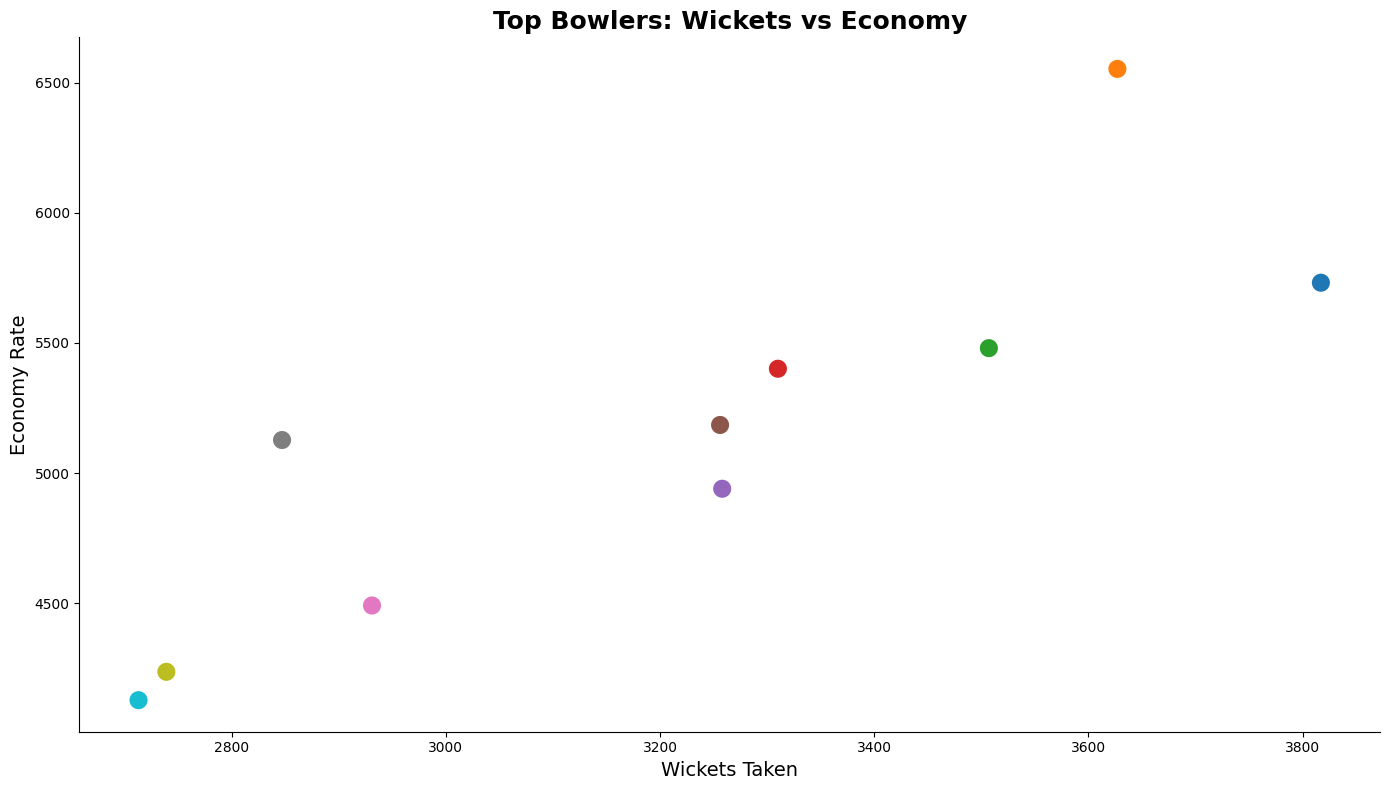

In [27]:
bowler_stats = data.groupby("bowler").agg(
    wickets=("wickets", "sum"),
    runs_conceded=("runs", "sum"),
    overs=("overs", "max")
)

bowler_stats["economy"] = bowler_stats["runs_conceded"] / bowler_stats["overs"]
top_bowlers = bowler_stats.sort_values("wickets", ascending=False).head(10)

plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=top_bowlers,
    x="wickets",
    y="economy",
    hue=top_bowlers.index,
    s=200,
    legend=False
)
plt.title("Top Bowlers: Wickets vs Economy", fontsize=18, weight='bold')
plt.xlabel("Wickets Taken", fontsize=14)
plt.ylabel("Economy Rate", fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

4. Performing Label Encoding

In [6]:
from sklearn.preprocessing import LabelEncoder

cat_cols = ['bat_team', 'bowl_team', 'venue', "batsman", "bowler"]

data_encoded = data.copy()

label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    data_encoded[col] = le.fit_transform(data_encoded[col])
    label_encoders[col] = le

5. Performing Feature Selection

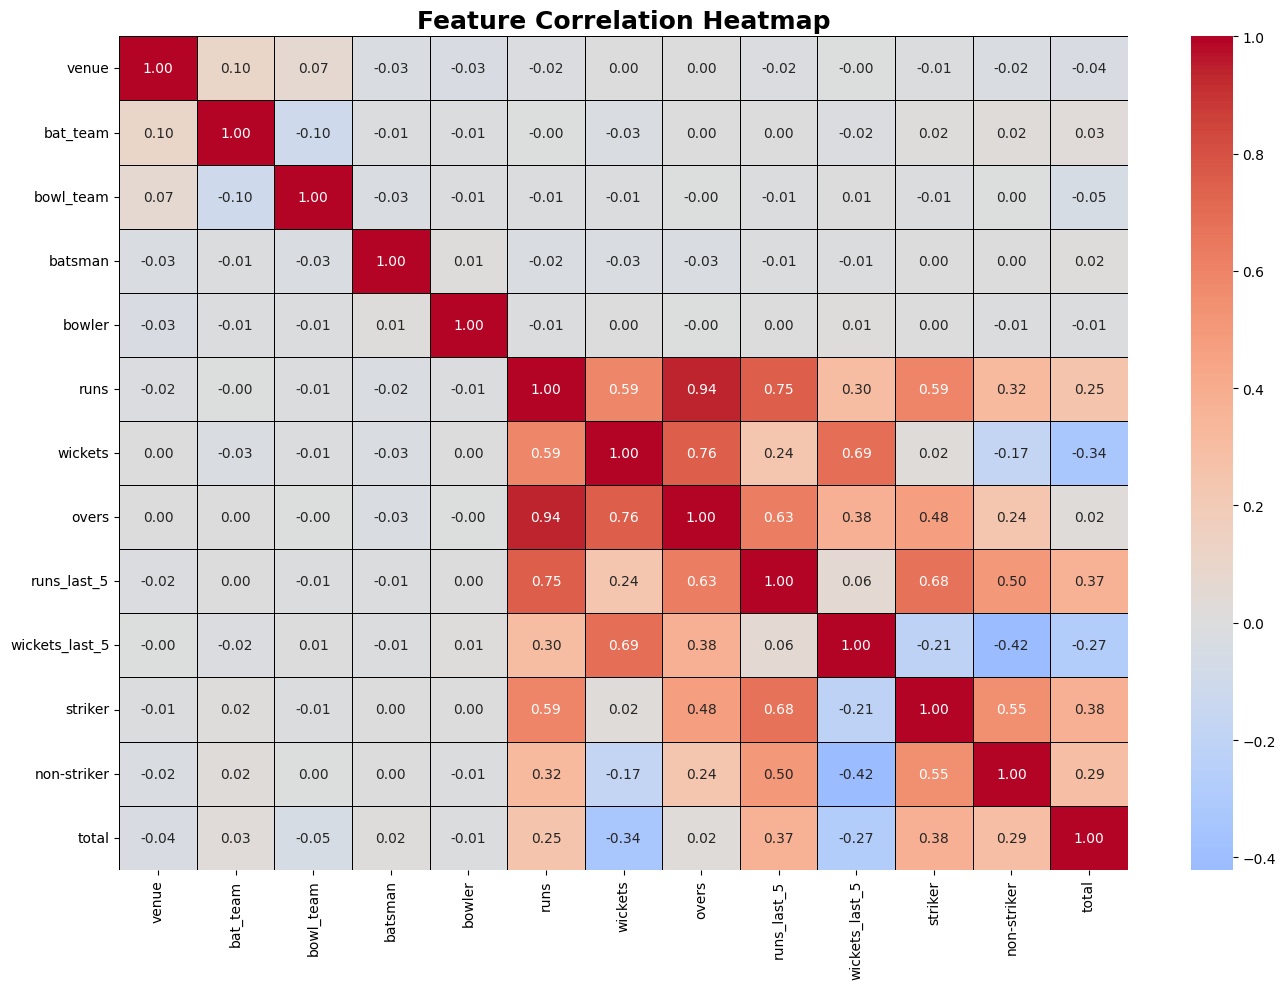

In [20]:
data_corr = data_encoded.drop(columns=["date", "mid"], axis=1)
plt.figure(figsize=(14, 10))
sns.heatmap(
    data_corr.corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor="black"
)
plt.title("Feature Correlation Heatmap", fontsize=18, weight='bold')
plt.tight_layout()
plt.show()

6. Splitting the Dataset into Training and Testing

In [8]:
from sklearn.model_selection import train_test_split
feature_cols = ['bat_team', 'bowl_team', 'venue', 'runs',
                'wickets', 'overs', 'batsman', 'bowler']

X = data_encoded[feature_cols]
y = data_encoded['total']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

7. Performing Feature Scaling


In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

8. Building the Neural Network

In [10]:
from keras.layers import Dense, Dropout, BatchNormalization

model = keras.Sequential([
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse')

9. Training the Model

In [11]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

model.fit(X_train_scaled, y_train,
          epochs=50, batch_size=64,
          validation_data=(X_test_scaled, y_test),
          callbacks=[callback])


Epoch 1/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 6841.3799 - val_loss: 406.3383
Epoch 2/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 582.0110 - val_loss: 390.2728
Epoch 3/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 539.1972 - val_loss: 439.1789
Epoch 4/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 515.6737 - val_loss: 382.5356
Epoch 5/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 508.4444 - val_loss: 376.3358
Epoch 6/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 490.8722 - val_loss: 376.2503
Epoch 7/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 479.9874 - val_loss: 366.8973
Epoch 8/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 473.3274 - val_loss: 357.4556
Epoch 9/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 460.8992 - val_loss: 366.3543
Epoch 10/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 461.8623 - val_loss: 394.9774
Epoch 11/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 447.6050 - val_loss: 376.0146

Plotting the loss and validation loss of the model.

<Axes: >

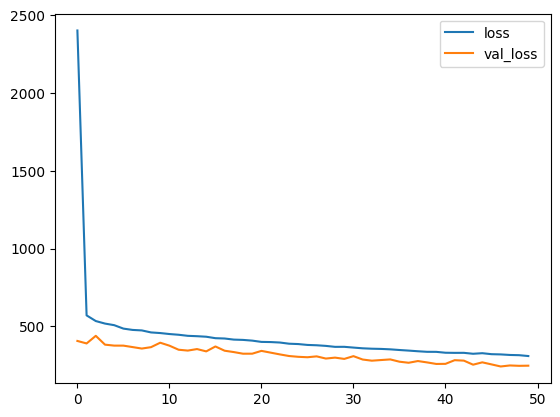

In [12]:
model_losses = pd.DataFrame(model.history.history)
model_losses.plot()

10. Evaluating the Model

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
predictions = model.predict(X_test_scaled)

mean_absolute_error(y_test, predictions)

713/713 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


11.206392288208008

11. Creating an Interactive Widget for Score Prediction

In [14]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings("ignore")

venue = widgets.Dropdown(options=list(
    label_encoders['venue'].classes_), description='Select Venue:')
venue.style = {'description_width': 'initial'}

batting_team = widgets.Dropdown(options=list(
    label_encoders['bat_team'].classes_), description='Select Batting Team:')
batting_team.style = {'description_width': 'initial'}

bowling_team = widgets.Dropdown(options=list(
    label_encoders['bowl_team'].classes_), description='Select Bowling Team:')
bowling_team.style = {'description_width': 'initial'}

striker = widgets.Dropdown(options=list(
    label_encoders['batsman'].classes_), description='Select Striker:')
striker.style = {'description_width': 'initial'}

bowler = widgets.Dropdown(options=list(
    label_encoders['bowler'].classes_), description='Select Bowler:')
bowler.style = {'description_width': 'initial'}

runs = widgets.BoundedIntText(
    value=0, min=0, max=200, description='Current Runs:',
    style={'description_width': 'initial'}
)

wickets = widgets.BoundedIntText(
    value=0, min=0, max=10, description='Wickets Down:',
    style={'description_width': 'initial'}
)

overs = widgets.BoundedFloatText(
    value=0.0, min=0.0, max=20.0, step=0.1, description='Overs Bowled:',
    style={'description_width': 'initial'}
)

predict_button = widgets.Button(description="Predict Score")

output = widgets.Output()


def predict_score(b):
    with output:
        clear_output()  # Clear previous output

        encoded_venue = label_encoders['venue'].transform([venue.value])[0]
        encoded_batting_team = label_encoders['bat_team'].transform(
            [batting_team.value])[0]
        encoded_bowling_team = label_encoders['bowl_team'].transform(
            [bowling_team.value])[0]
        encoded_striker = label_encoders['batsman'].transform([striker.value])[
            0]
        encoded_bowler = label_encoders['bowler'].transform([bowler.value])[0]

        input_features = [
            encoded_batting_team,
            encoded_bowling_team,
            encoded_venue,
            runs.value,
            wickets.value,
            overs.value,
            encoded_striker,
            encoded_bowler
        ]


        input_array = np.array(input_features).reshape(1, -1)
        input_array = scaler.transform(input_array)
        predicted_score = model.predict(input_array)

        print(f"Predicted Total Runs: {int(predicted_score[0])}")


predict_button.on_click(predict_score)

ui_left = widgets.VBox([venue, batting_team, bowling_team])
ui_right = widgets.VBox([striker, bowler, runs, wickets, overs])

display(widgets.HBox([ui_left, ui_right]))
display(predict_button, output)

Button(description='Predict Score', style=ButtonStyle())

Output()